In [1]:
# Setup relevant libraries
import os
import sys
sys.path.append(os.path.abspath("..")) 

os.chdir("/oscar/data/gk/voommen/Gen4Turbulence/2_forecasting/GenCFD") # Replace with the correct path to root

import warnings
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch import optim
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, Union

import GenCFD
from GenCFD import diffusion as dfn_lib
from GenCFD import model, train, solvers, utils

Tensor = torch.Tensor
array = np.ndarray

DATA_STD = 0.5 # Fixed parameter but can also be learnable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 0

# Setting global seed for reproducibility
torch.manual_seed(SEED)  # For CPU operations
torch.cuda.manual_seed(SEED)  # For GPU operations
torch.cuda.manual_seed_all(SEED)  # Ensure all GPUs (if multi-GPU) are set

import time

In [2]:
from argparse import ArgumentParser

In [3]:
import os
import math

import torch
import torch.distributed as dist
from torch.distributed import is_initialized
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from GenCFD.train import training_loop
from GenCFD.utils.dataloader_builder import get_dataset_loader
from GenCFD.utils.gencfd_builder import (
    create_denoiser,
    create_callbacks,
    save_json_file,
)
from GenCFD.utils.parser_utils import train_args

torch.set_float32_matmul_precision("high")  # Better performance on newer GPUs!
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 0

# Setting global seed for reproducibility
torch.manual_seed(SEED)  # For CPU operations
torch.cuda.manual_seed(SEED)  # For GPU operations
torch.cuda.manual_seed_all(SEED)  # Ensure all GPUs (if multi-GPU) are set

In [4]:
def init_distributed_mode(args):
    """Initialize a Distributed Data Parallel Environment"""

    args.local_rank = int(os.getenv("LOCAL_RANK", -1))  # Get from environment variable

    if args.local_rank == -1:
        raise ValueError(
            "--local_rank was not set. Ensure torchrun is used to launch the script."
        )

    torch.cuda.set_device(args.local_rank)
    dist.init_process_group(
        backend="nccl", rank=args.local_rank, world_size=args.world_size
    )

    device = torch.device(f"cuda:{args.local_rank}")
    print(" ")
    print(f"DDP initialized with rank {args.local_rank} and device {device}.")

    return args, device

In [5]:

def parse_tuple(value):
    """Allows for tuples as arguments."""

    if value is None or value.lower() == "none":
        return None
    try:
        return tuple(map(int, value.strip("()").split(",")))
    except ValueError:
        raise ValueError(f"Invalid tuple format: {value}")


def str_to_bool(value):
    """Transform a string to a bool."""

    if value.lower() in ["true", "t", "1", "yes", "y"]:
        return True
    elif value.lower() in ["false", "f", "0", "no", "n"]:
        return False

    if isinstance(value, bool):  # If it's already a boolean, return as is
        return value


def add_base_options(parser: ArgumentParser):
    """General base arguments for training and inference"""

    group = parser.add_argument_group("base")
    # Mixed precision calculations activate a scalar for the gradient propagation and uses float16 where possible
    group.add_argument(
        "--work_dir",
        default="datasets",
        type=str,
        help="If empty, will use defaults according to the specified dataset.",
    )
    group.add_argument(
        "--save_dir",
        default=None,
        type=str,
        help="Specify your directory where training or evaluation results should be saved",
    )
    group.add_argument(
        "--model_dir",
        default=None,
        type=str,
        help="Set a path to a pretrained model for inference",
    )
    group.add_argument(
        "--dtype",
        default=torch.float32,
        type=torch.dtype,
        help="Set the precision for PyTorch tensors by defining the dtype",
    )
    group.add_argument(
        "--use_mixed_precision",
        default=True,
        type=str_to_bool,
        help="For memory efficiency activate mixed precision calculations",
    )


def add_parallelization_options(parser: ArgumentParser):
    """Arguments for Distributed Training"""

    group = parser.add_argument_group("distributed")
    group.add_argument(
        "--local_rank", type=int, default=-1, help="Local rank for distributed training"
    )
    group.add_argument(
        "--world_size", type=int, default=1, help="Total number of processes for DDP"
    )


def add_data_options(parser: ArgumentParser):
    """Relevant parser arguments for the dataloader"""

    group = parser.add_argument_group("dataset")
    group.add_argument(
        "--dataset",
        default="DataIC_Vel",
        type=str,
        choices=[
            # Datasets for Training
            "ShearLayer2D",
            "CloudShock2D",
            "RichtmyerMeshkov2D",
            "ShearLayer3D",
            "TaylorGreen3D",
            "Nozzle3D",
            # Conditional (Perturbed) Datasets for Evaluation
            "ConditionalShearLayer2D",
            "ConditionalCloudShock2D",
            "ConditionalShearLayer3D",
            "ConditionalTaylorGreen3D",
            "ConditionalNozzle3D",
            "HIT3D"
        ],
        help="Name of the dataset, available choices",
    )
    group.add_argument("--batch_size", default=5, type=int, help="Choose a batch size")
    group.add_argument(
        "--worker",
        default=0,
        type=int,
        help="Choose the number of worker for parallel processing",
    )


def add_model_options(parser: ArgumentParser):
    """Relevant parser arguments for the UNet architecture"""

    group = parser.add_argument_group("model")
    # Model settings
    group.add_argument(
        "--model_type",
        default="PreconditionedDenoiser",
        type=str,
        choices=[
            "PreconditionedDenoiser",
            "UNet",
            "PreconditionedDenoiser3D",
            "UNet3D",
        ],
        help="Choose a valid Neural Network Model architecture",
    )
    group.add_argument(
        "--num_channels",
        default=(64, 128),
        type=parse_tuple,
        help="Number of channels for down and upsampling",
    )
    group.add_argument(
        "--downsample_ratio",
        default=(2, 2),
        type=parse_tuple,
        help="Choose a downsample ratio",
    )
    # Attention settings
    group.add_argument(
        "--use_attention",
        default=True,
        type=str_to_bool,
        help="Choose if attention blocks should be used",
    )
    group.add_argument(
        "--num_blocks", default=4, type=int, help="Choose number of Attention blocks"
    )
    group.add_argument(
        "--num_heads",
        default=8,
        type=int,
        help="Choose number of heads for multihead attention",
    )
    group.add_argument(
        "--normalize_qk",
        default=False,
        type=str_to_bool,
        help="Choose if Query and Key matrix should be normalized",
    )
    # Embedding settings
    group.add_argument(
        "--noise_embed_dim",
        default=128,
        type=int,
        help="Choose noise embedding dimension",
    )
    group.add_argument(
        "--use_position_encoding",
        default=True,
        type=str_to_bool,
        help="Use position encoding True or False",
    )
    # General settings
    group.add_argument(
        "--padding_method",
        default="circular",
        type=str,
        choices=[
            "circular",
            "constant",
            "reflect",
            "lonlat",
            "latlon",
            "same",
            "zeros",
        ],
        help="Choose a proper padding method from the list of choices",
    )
    group.add_argument(
        "--dropout_rate", default=0.0, type=float, help="Choose a proper dropout rate"
    )
    group.add_argument(
        "--use_hr_residual",
        default=False,
        type=str_to_bool,
        help="Dropout rate for classifier-free guidance",
    )
    group.add_argument(
        "--sigma_data",
        default=0.5,
        type=float,
        help="This can be a fixed in [0, 1] or learnable parameter",
    )
    group.add_argument(
        "--resize_to_shape",
        default=None,
        type=parse_tuple,
        help="Choose a shape to resize inside the UNet. Necessary if dataset resolution changes",
    )
    # Compile model setting
    group.add_argument(
        "--compile",
        action="store_true",
        default=False,
        help="If True, model will be compiled. This allows for faster training and inference",
    )


def add_denoiser_options(parser: ArgumentParser):
    """Relevant parameter for the DenoisingModel"""

    group = parser.add_argument_group("denoiser")
    group.add_argument(
        "--diffusion_scheme",
        default="create_variance_exploding",
        choices=["create_variance_preserving", "create_variance_exploding"],
        help="Choose a valid diffusion scheme",
    )
    group.add_argument(
        "--sigma",
        default="exponential_noise_schedule",
        choices=[
            "exponential_noise_schedule",
            "power_noise_schedule",
            "tangent_noise_schedule",
        ],
        help="Choose a valid noise scheduler sigma",
    )
    group.add_argument(
        "--noise_sampling",
        default="log_uniform_sampling",
        type=str,
        choices=["log_uniform_sampling", "time_uniform_sampling", "normal_sampling"],
        help="Choose a valid noise sampler from the list of choices",
    )
    group.add_argument(
        "--noise_weighting",
        default="edm_weighting",
        type=str,
        choices=["edm_weighting", "likelihood_weighting"],
        help="Choose a valid weighting method from the list of choices",
    )
    group.add_argument(
        "--num_eval_noise_levels",
        default=5,
        type=int,
        help="Set number of noise levels for evaluation during training",
    )
    group.add_argument(
        "--num_eval_cases_per_lvl",
        default=1,
        type=int,
        help="Set number of evaluation samples per noise level",
    )
    group.add_argument(
        "--min_eval_noise_lvl",
        default=1e-3,
        type=float,
        help="Minimum noise level during evaluation",
    )
    group.add_argument(
        "--max_eval_noise_lvl",
        default=50.0,
        type=float,
        help="Maximum noise level during evaluation",
    )
    group.add_argument(
        "--consistent_weight",
        default=0.0,
        type=float,
        help="Set weighting for some loss terms",
    )


def add_trainer_options(parser: ArgumentParser):
    """Parser Arguments for the Trainer"""

    group = parser.add_argument_group("trainer")
    # EMA ... Exponential Moving Average
    group.add_argument(
        "--ema_decay",
        default=0.999,
        type=float,  # Before: 0.999
        help="Choose a decay rate for the EMA model parameters",
    )
    group.add_argument(
        "--peak_lr",
        default=1e-4,
        type=float,  # 1e-4 # before: 1e-3
        help="Choose a learning rate for the Adam optimizer",
    )
    group.add_argument(
        "--weight_decay",
        default=0.01,
        type=float,  # 0.01 , 1e-5 # before: 0.01
        help="Regularization strength for the optimizer",
    )


def add_training_options(parser: ArgumentParser):
    """Parser arguments for the training loop"""

    group = parser.add_argument_group("training")
    group.add_argument(
        "--num_train_steps",
        default=10_000,
        type=int,
        help="Choose number of training steps",
    )
    group.add_argument(
        "--metric_aggregation_steps",
        default=5,
        type=int,
        help="trainer runs this number of steps until training metrics are aggregated",
    )
    group.add_argument(
        "--eval_every_steps",
        default=5,
        type=int,
        help="Period at which an evaluation loop runs",
    )
    group.add_argument(
        "--num_batches_per_eval",
        default=5,
        type=int,
        help="Number of steps until evaluation metrics are aggregated",
    )
    group.add_argument(
        "--run_sanity_eval_batch",
        default=True,
        type=str_to_bool,
        help="Sanity check to spot early mistakes or runtime issues",
    )
    group.add_argument(
        "--checkpoints",
        default=True,
        type=str_to_bool,
        help="Saves or Loads parameters from a checkpoint",
    )
    group.add_argument(
        "--save_every_n_steps",
        default=10000,
        type=int,
        help="Saves a checkpoint of the model and optimizer after every n steps",
    )
    group.add_argument(
        "--track_memory",
        action="store_true",
        default=False,
        help="If True, memory tracer during training is activated else returns zeros.",
    )


def add_sampler_options(parser: ArgumentParser):
    """Parser arguments for the sampler"""

    group = parser.add_argument_group("sampler")
    group.add_argument(
        "--time_step_scheduler",
        default="edm_noise_decay",
        type=str,
        choices=["edm_noise_decay", "exponential_noise_decay", "uniform_time"],
        help="Choose a valid time step scheduler for solving an SDE",
    )
    group.add_argument(
        "--sampling_steps",
        default=128,
        type=int,
        help="Define sampling steps for solving the SDE, min value should be 32",
    )
    group.add_argument(
        "--apply_denoise_at_end",
        default=True,
        type=str_to_bool,
        help="If True applies the denoise function another time to the terminal states",
    )
    group.add_argument(
        "--return_full_paths",
        default=False,
        type=str_to_bool,
        help="If True the output of .generate() and .denoise() will contain the complete sampling path",
    )
    group.add_argument(
        "--rho", default=7, type=int, help="Set decay rate for the noise over time"
    )


def add_sde_options(parser: ArgumentParser):
    """Parser arguments for the Euler Maruyama Method"""

    group = parser.add_argument_group("sde")
    group.add_argument(
        "--integrator",
        default="EulerMaruyame",
        type=str,
        help="Choose a valid SDE Solver",
    )
    group.add_argument(
        "--time_axis_pos",
        default=0,
        type=int,
        help="Defines the index where the time axis should be placed",
    )
    group.add_argument(
        "--terminal_only",
        default=True,
        type=str_to_bool,
        help="If set to False returns the full path otherwise only the terminal state",
    )


def add_evaluation_options(parser: ArgumentParser):
    """Parser arguments to compute Metrics for the inference pipeline"""
    group = parser.add_argument_group("evaluation")
    group.add_argument(
        "--compute_metrics",
        action="store_true",
        default=False,
        help="If True metrics like mean and std will be computed",
    )
    group.add_argument(
        "--monte_carlo_samples",
        default=100,
        type=int,
        help="Choose a number of monte carlo samples to compute statistical metrics",
    )
    group.add_argument(
        "--visualize",
        action="store_true",
        default=False,
        help="If True an image of a single generated result will be stored",
    )
    group.add_argument(
        "--save_gen_samples",
        action="store_true",
        default=False,
        help="If True an npz file with generated and groundtruth samples will be stored",
    )

# def train_args():
#     """Define the Parser for the training"""

#     parser = ArgumentParser()
#     add_base_options(parser)
#     add_parallelization_options(parser)
#     add_data_options(parser)
#     add_model_options(parser)
#     add_denoiser_options(parser)
#     add_trainer_options(parser)
#     add_training_options(parser)
#     return parser #.parse_args()

def _getenv_cast(name, default, caster):
    """Read env var NAME and cast; fall back to default on any problem."""
    val = os.getenv(name, None)
    if val is None or val == "":
        return default
    try:
        if caster is bool:  # reuse your str_to_bool
            return str_to_bool(str(val))
        if caster is tuple:  # reuse your parse_tuple
            return parse_tuple(val)
        return caster(val)
    except Exception:
        return default

def train_args(argv=None):
    parser = ArgumentParser()
    add_base_options(parser); add_parallelization_options(parser)
    add_data_options(parser); add_model_options(parser)
    add_denoiser_options(parser); add_trainer_options(parser); add_training_options(parser)

    # hardcoded preset for your HIT3D run ##############################################################################
    parser.set_defaults(
        dataset="HIT3D",
        model_type="PreconditionedDenoiser3D",
        save_dir="runs/hit3d_128_lb1_lf4_2gpu",
        batch_size=3,
        num_blocks=1,
        num_channels=(16,32),
        padding_method="circular",
        use_mixed_precision=True,
        world_size=1,
        num_train_steps=100000,
        metric_aggregation_steps=1,
        eval_every_steps=1,
        num_batches_per_eval=1,

        # add HIT3D defaults *as parser fields* too:
        hit3d_lb=1,
        hit3d_lf=4,
        hit3d_norm_lead="1",
        hit3d_ret_block="0",
    )
    
    args = parser.parse_args([] if argv is None else argv)

    # propagate to env so HIT3D sees them
    if args.dataset == "HIT3D":
        os.environ.setdefault("HIT3D_LB", str(args.hit3d_lb))
        os.environ.setdefault("HIT3D_LF", str(args.hit3d_lf))
        os.environ.setdefault("HIT3D_NORM_LEAD", str(args.hit3d_norm_lead))
        os.environ.setdefault("HIT3D_RET_BLOCK", str(args.hit3d_ret_block))

    return args

    



In [6]:
# get arguments for training
args = train_args()

# Instead of parse_args(), do:
# args, _ = train_args().parse_known_args()

args.world_size=1

# Initialize distributed mode (if multi-GPU)
if args.world_size > 1:
    args, device = init_distributed_mode(args)
else:
    print(" ")
    print(f"Used device: {device}")


train_dataloader, eval_dataloader, dataset, time_cond = get_dataset_loader(
    args=args,
    name=args.dataset,
    batch_size=args.batch_size,
    num_worker=args.worker,
    prefetch_factor=2,  # Default DataLoader value
    split=True,
    split_ratio=0.99,
)

print("train_len:", len(train_dataloader.dataset))
print("eval_len :", len(eval_dataloader.dataset))

if (args.world_size > 1 and args.local_rank == 0) or args.world_size == 1:
    # Save parameters in a JSON File
    save_json_file(
        args=args,
        time_cond=time_cond,
        split_ratio=0.8,
        out_shape=dataset.output_shape,  # output shape of the prediction
        input_channel=dataset.input_channel,
        output_channel=dataset.output_channel,
        spatial_resolution=dataset.spatial_resolution,
        device=device,
        seed=SEED,
    )

denoising_model = create_denoiser(
    args=args,
    input_channels=dataset.input_channel,
    out_channels=dataset.output_channel,
    spatial_resolution=dataset.spatial_resolution,
    time_cond=time_cond,
    device=device,
    dtype=args.dtype,
    use_ddp_wrapper=True,
)

if (args.world_size > 1 and args.local_rank == 0) or args.world_size == 1:
    # Print number of Parameters:
    model_params = sum(
        p.numel() for p in denoising_model.denoiser.parameters() if p.requires_grad
    )
    print(" ")
    print(f"Total number of model parameters: {model_params}")
    print(" ")

# Initialize optimizer
optimizer = optim.AdamW(
    denoising_model.denoiser.parameters(),
    lr=args.peak_lr,
    weight_decay=args.weight_decay,
)

trainer = training_loop.trainers.DenoisingTrainer(
    model=denoising_model,
    optimizer=optimizer,
    device=device,
    ema_decay=args.ema_decay,
    store_ema=True,  # Store ema model as well
    track_memory=args.track_memory,
    use_mixed_precision=args.use_mixed_precision,
    is_compiled=args.compile,
    world_size=args.world_size,
    local_rank=args.local_rank,
)


 
Used device: cuda
root: GenCFD/data/HIT3D_128
root: GenCFD/data/HIT3D_128
root: GenCFD/data/HIT3D_128
train_len: 156
eval_len : 36
 
Training configuration saved to runs/hit3d_128_lb1_lf4_2gpu/training_config.json
 
Compilation mode: False, World Size: 1
 
Total number of model parameters: 6155908
 


In [7]:
model_path = "/oscar/data/gk/voommen/no_diffusion/hit_3d/GenCFD_lf4/runs/hit3d_128_lb1_lf4_2gpu/checkpoints"
latest_model_path = utils.get_latest_checkpoint(model_path)

trained_state = train.TrainState.restore_from_checkpoint(
    latest_model_path,
    model=denoising_model.denoiser,
    optimizer=trainer.optimizer,
    is_compiled=trainer.is_compiled,
    is_parallelized=False,
    use_ema=True,
    device=device,
)

In [8]:
output_shape = (4, 128, 128, 128)

diffusion_scheme = dfn_lib.Diffusion.create_variance_exploding(
    sigma=dfn_lib.tangent_noise_schedule(device=device),
    data_std=DATA_STD,
)

denoise_fn = trainer.inference_fn_from_state_dict(
    trained_state,
    denoiser=denoising_model.denoiser,
    lead_time=True,
)

integrator = solvers.EulerMaruyama(
    time_axis_pos=0,
    terminal_only=True
)

tspan = dfn_lib.edm_noise_decay(
    scheme=diffusion_scheme,
    rho=7,
    # Minimum of 30 steps required
    num_steps=128,
    end_sigma=1e-3,
    dtype=torch.float32,
    device=device
)

sampler = dfn_lib.SdeSampler(
    input_shape=output_shape,
    scheme=diffusion_scheme,
    denoise_fn=denoise_fn,
    tspan=tspan,
    integrator=integrator,
    guidance_transforms= (),
    apply_denoise_at_end=True,
    return_full_paths=False,
    device=device,
    dtype=torch.float32
)

In [9]:
tensor = lambda x: torch.tensor(x, dtype=torch.float32, device=device)

# GFLOPs

In [13]:
from torch.utils.flop_counter import FlopCounterMode  # PyTorch 2.x
from torchtnt.utils.flops import FlopTensorDispatchMode
import copy

class Wrapper(nn.Module):
    def __init__(self, base, num_steps=32):
        super().__init__()
        self.base = base
        self.num_steps = num_steps

    def forward(self, x, lead_time):
        # Re-enable autograd inside, even though THOP disabled it outside
        with torch.enable_grad():
            y = self.base.generate(num_samples=x.shape[0], y=x, lead_time=lead_time)
            if isinstance(y, (tuple, list)):
                y = y[0]
        return y


dummy_x = torch.randn(1, 4, 128, 128, 128, dtype=torch.float32, device=device)
lead_time = torch.randn(1, dtype=torch.float32, device=device)

wrapper_model = Wrapper(sampler).eval()

wrapper_model.eval()

with FlopTensorDispatchMode(wrapper_model) as m:
    _ = wrapper_model(dummy_x, lead_time)

flops_by_module = copy.deepcopy(m.flop_counts)

# Each entry is a defaultdict; sum their inner values
total_flops = sum(
    sum(op_counts.values()) for op_counts in flops_by_module.values()
)
print(f"Total FLOPs: {total_flops:,}")

/users/voommen/apps/GenCFD/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total FLOPs: 45,297,990,369,280


# Inference Time

In [16]:
inference_time_ls = []

sampler#.eval()

for i in range(15):
    begin_time = time.time()
    # with torch.no_grad():
    y_pred = sampler.generate(num_samples=dummy_x.shape[0], y=dummy_x, lead_time=lead_time)
    
    end_time = time.time()
    inference_time = end_time - begin_time
    print(f"Inference time: {inference_time:.5f}")
    inference_time_ls.append(inference_time)

print()
print(f"mean: {np.mean(inference_time_ls[5:])}")

Inference time: 7.72554
Inference time: 7.81171
Inference time: 7.81503
Inference time: 7.80538
Inference time: 7.80264
Inference time: 7.79935
Inference time: 7.80182
Inference time: 7.80120
Inference time: 7.80316
Inference time: 7.80965
Inference time: 7.80155
Inference time: 7.80344
Inference time: 7.80903
Inference time: 7.80470
Inference time: 7.80812

mean: 7.804201197624207


# Peak VRAM

In [18]:
torch.backends.cudnn.benchmark = False  # keep runs reproducible




# Warmup
# with torch.no_grad():
y_pred = sampler.generate(num_samples=dummy_x.shape[0], y=dummy_x, lead_time=lead_time)


torch.cuda.synchronize()

torch.cuda.reset_peak_memory_stats() 
# with torch.no_grad():
y_pred = sampler.generate(num_samples=dummy_x.shape[0], y=dummy_x, lead_time=lead_time)

torch.cuda.synchronize()


# ---- Read peaks (bytes) and report in GB ----
peak_alloc_GB   = torch.cuda.max_memory_allocated()  / 1e9
peak_resvd_GB   = torch.cuda.max_memory_reserved()   / 1e9
print(f"Peak VRAM (allocated): {peak_alloc_GB:.4f} GB")
print(f"Peak VRAM (reserved) : {peak_resvd_GB:.4f} GB")
print("Config: batch=1, dtype=", torch.float32, ", device=", device)

Peak VRAM (allocated): 28.5566 GB
Peak VRAM (reserved) : 30.9707 GB
Config: batch=1, dtype= torch.float32 , device= cuda


In [10]:
traj = np.load('GenCFD/data/HIT3D_128/trajectory.npy').transpose(1,0,2,3,4)[164:]
print(f"traj: {traj.shape}")

traj: (40, 4, 128, 128, 128)


In [11]:
def batched_sampling(sampler, x, lead_time, batch_size=2):
    #x - [BS, nf, nx, ny, nz]
    #lead_time - [BS,]

    n_samples = x.shape[0]

    pred_ls = []

    for start in range(0, n_samples, batch_size):
        end = start+batch_size
        x_sample = x[start:end]
        lead_time_sample = lead_time[start:end]
        pred = sampler.generate(
                        num_samples=x_sample.shape[0],
                        y=tensor(x_sample),
                        lead_time=lead_time_sample,
                    ).detach().cpu().numpy() #[LF, NF, nx, ny, nz]

        pred_ls.append(pred)

    pred = np.concatenate(pred_ls, axis=0)
    return pred

In [12]:
LB = 1
LF = 4    ##############################################################################

lead_time = tensor( np.arange(1, LF+1)/LF )

y_true = traj[4:]
y_pred_ls = []


x_ls = []
for i in range(LF):
    x_ls.append(traj[3:4])

x = np.concatenate(x_ls, axis=0)
print(f"x: {x.shape}")

nt = 0
while y_pred_ls is None or len(y_pred_ls)*LF <= 36:
    begin_time = time.time()
    temp_pred = batched_sampling(sampler, x, lead_time) 
    
    # sampler.generate(
    #                     num_samples=x.shape[0],
    #                     y=tensor(x),
    #                     lead_time=lead_time,
    #                 ).detach().cpu().numpy() #[LF, NF, nx, ny, nz]

    y_pred_ls.append(temp_pred)
    temp_x = temp_pred[-LB:]

    x_ls = []
    for i in range(LF):
        x_ls.append(temp_x)
    x = np.concatenate(x_ls, axis=0)
    nt = nt + LF
    print(f"{nt-LF} to {nt} Complete. Elapsed Time: {time.time() - begin_time:.2f}s")

    
y_pred = np.concatenate(y_pred_ls, axis=0)[:36]  

y_pred.shape

x: (4, 4, 128, 128, 128)
0 to 4 Complete. Elapsed Time: 26.24s
4 to 8 Complete. Elapsed Time: 25.31s
8 to 12 Complete. Elapsed Time: 25.31s
12 to 16 Complete. Elapsed Time: 25.31s
16 to 20 Complete. Elapsed Time: 25.30s
20 to 24 Complete. Elapsed Time: 25.31s
24 to 28 Complete. Elapsed Time: 25.32s
28 to 32 Complete. Elapsed Time: 25.31s
32 to 36 Complete. Elapsed Time: 25.31s
36 to 40 Complete. Elapsed Time: 25.31s


(36, 4, 128, 128, 128)

In [13]:
y_true.shape

(36, 4, 128, 128, 128)

In [14]:
 np.arange(0,37,4)

array([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36])

/tmp/ipykernel_16809/1880513556.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


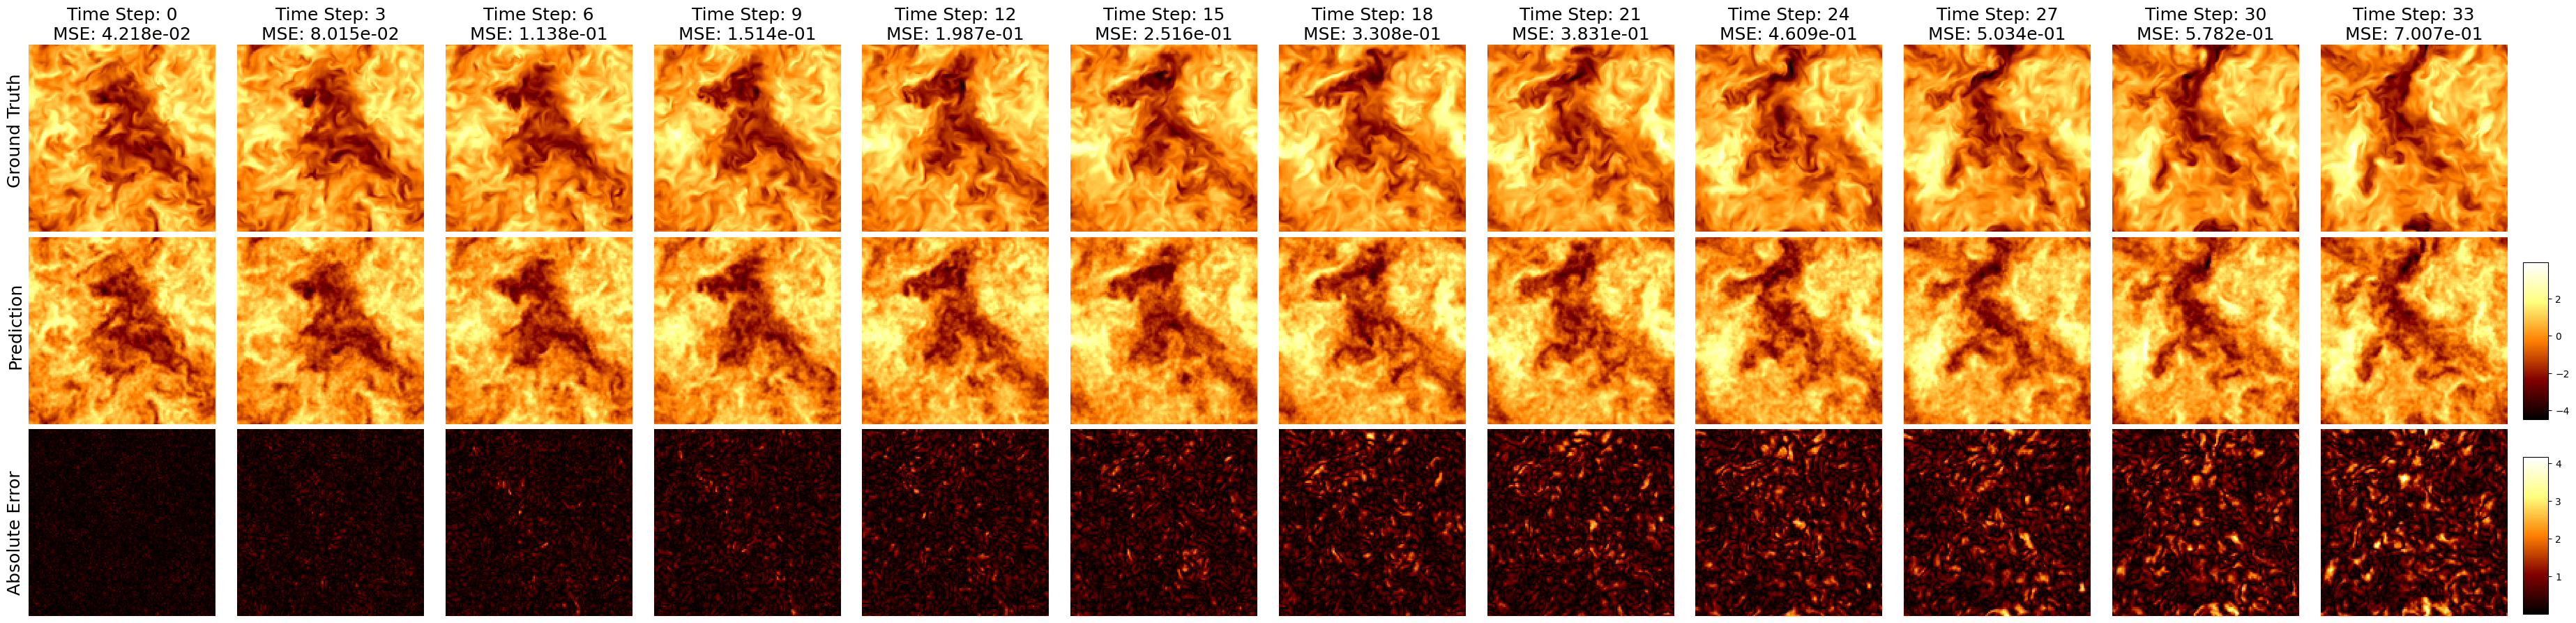

In [16]:
# nt, nx, ny = 5, 128, 128  # Update these dimensions based on your actual data

sample_id = 0
f_no = 0
z_id = 64

t_id_ls = np.arange(1,37,3)-1

CMAP = 'afmhot'

# Generate sample data for demonstration
true_values = y_true[:,f_no, :,:, z_id][t_id_ls]
predictions = y_pred[:,f_no, :,:, z_id][t_id_ls]
t_ls = np.arange(36)[t_id_ls]

nt, nx, ny = predictions.shape

# Calculate absolute error
abs_error = np.abs(true_values - predictions)

# Create a figure and axes
fig, axs = plt.subplots(3, nt, figsize=(nt*3, 9))

# Define the maximum value for the color scale in truth and prediction
vmax = max(true_values.max(), predictions.max())
vmax_error = abs_error.max()
vmin = max(true_values.min(), predictions.min())
vmin_error = abs_error.min()

for i in range(nt):
    # Plot True values
    im1 = axs[0, i].imshow(true_values[i], cmap=CMAP, interpolation='nearest', vmin=vmin, vmax=vmax)
    axs[0, i].set_title(f'Time Step: {t_ls[i]}\nMSE: {np.mean( (true_values[i] - predictions[i])**2 ):.3e}', fontsize=18)
    axs[0, i].axis('off')
    
    # Plot Predictions
    im2 = axs[1, i].imshow(predictions[i], cmap=CMAP, interpolation='nearest', vmin=vmin, vmax=vmax)
    axs[1, i].axis('off')
    
    # Plot Absolute Error
    im3 = axs[2, i].imshow(abs_error[i], cmap=CMAP, interpolation='nearest', vmin=vmin_error, vmax=vmax_error)
    axs[2, i].axis('off')

# Set colorbars
# cbar = fig.colorbar(im1, ax=axs[0:2, :], orientation='vertical', fraction=0.02, pad=0.04)
# cbar.set_label('Scale for Truth and Predictions')

# cbar_error = fig.colorbar(im3, ax=axs[2, :], orientation='vertical', fraction=0.02, pad=0.04)
# cbar_error.set_label('Scale for Absolute Error')

# Add colorbars
cbar_ax1 = fig.add_axes([1, 0.33, 0.01, 0.25])  # [left, bottom, width, height]
cbar1 = fig.colorbar(im1, cax=cbar_ax1)

cbar_ax2 = fig.add_axes([1, 0.02, 0.01, 0.25])
cbar2 = fig.colorbar(im3, cax=cbar_ax2)


# Add vertical labels
fig.text(0.001, 0.79, 'Ground Truth', va='center', ha='center', rotation='vertical', fontsize=18)
fig.text(0.001, 0.48, 'Prediction', va='center', ha='center', rotation='vertical', fontsize=18)
fig.text(0.001, 0.15, 'Absolute Error', va='center', ha='center', rotation='vertical', fontsize=18)


# Adjust layout
fig.tight_layout()

plt.show()

In [17]:
print(f"y_true: {y_true.shape}")
print(f"y_pred: {y_pred.shape}")

np.save("y_true_128.npy", y_true)
np.save("y_pred_128.npy", y_pred)

y_true: (36, 4, 128, 128, 128)
y_pred: (36, 4, 128, 128, 128)


# Comparison

In [19]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "serif"

In [20]:
y_true = np.load("y_true_128.npy")
gencfd = np.load("y_pred_128.npy")
advno  = np.load("/oscar/data/gk/voommen/no_diffusion/hit_3d/tcunet_lb4_lf4_periodic/gan/TEST_PRED.npy")

advno = advno[0].transpose(1,0,2,3,4)

print(f"y_true: {y_true.shape}")
print(f"gencfd: {gencfd.shape}")
print(f"advno : {advno.shape}")

y_true: (36, 4, 128, 128, 128)
gencfd: (36, 4, 128, 128, 128)
advno : (36, 4, 128, 128, 128)


In [21]:
DTYPE = torch.float32
def compute_tke_spectrum_timeseries_torch(u_all, lx, ly, lz, smooth=False, device='cpu'):
    """
    Compute TKE spectrum over time without loops using PyTorch.
    
    Parameters:
    -----------
    u_all : torch.Tensor
        Tensor of shape [3, ntime, nx, ny, nz] with velocity components.
    lx, ly, lz : float
        Domain sizes.
    smooth : bool
        Apply optional smoothing.
    device : str
        Device to use.

    Returns:
    --------
    knyquist : float
    wave_numbers : torch.Tensor [maxbin]
    tke_spectrum : torch.Tensor [ntime, maxbin]
    """
    u_all = u_all.transpose(1,0,2,3,4)[:3]
    u_all = torch.tensor(u_all, dtype=DTYPE, device=device) # [3, ntime, nx, ny, nz]
    nf, ntime, nx, ny, nz = u_all.shape
    assert nf == 3, "First dimension must be 3 (velocity components)"

    ntot = nx * ny * nz

    # FFT
    uh_all = torch.fft.fftn(u_all, dim=(-3, -2, -1)) / ntot  # [3, ntime, nx, ny, nz]

    # Compute energy: sum of squares of real and imaginary parts
    energy = 0.5 * (uh_all.real**2 + uh_all.imag**2).sum(dim=0)  # [ntime, nx, ny, nz]

    # Wavenumber grids
    kx = torch.fft.fftfreq(nx, d=lx / nx, device=device)
    ky = torch.fft.fftfreq(ny, d=ly / ny, device=device)
    kz = torch.fft.fftfreq(nz, d=lz / nz, device=device)
    KX, KY, KZ = torch.meshgrid(kx, ky, kz, indexing='ij')
    K_mag = torch.sqrt(KX**2 + KY**2 + KZ**2)  # [nx, ny, nz]

    # Flatten for binning
    k_bins = torch.round(K_mag.flatten() / K_mag.max() * (nx // 2)).to(torch.int64)  # [npts]
    max_bin = k_bins.max().item() + 1

    wave_numbers = torch.arange(max_bin, device=device) * (2 * np.pi / ((lx + ly + lz)/3))

    # Flatten energy: [ntime, npts]
    energy_flat = energy.view(ntime, -1)  # [ntime, npts]

    # Allocate spectrum
    tke_spectrum = torch.zeros(ntime, max_bin, device=device)

    # Vectorized binning using broadcasting + scatter_add
    for k in range(max_bin):
        mask = (k_bins == k)
        if mask.any():
            tke_spectrum[:, k] = energy_flat[:, mask].sum(dim=1)

    if smooth:
        kernel = torch.ones(5, device=device) / 5
        kernel = kernel[None, None, :]
        tke_spectrum = torch.nn.functional.conv1d(
            tke_spectrum[:, None, :], kernel, padding=2
        ).squeeze(1)

    knyquist = (2 * np.pi / ((lx + ly + lz)/3)) * min(nx, ny, nz) / 2

    return knyquist, wave_numbers.detach().cpu().numpy(), tke_spectrum.detach().cpu().numpy()  # [ntime, maxbin]


def plot_slices_grid(
    data_ls, t_ls, wavenumbers, spec_ls, f_no=0, z_id=64, y_label_ls=None,
    cmap="afmhot", figsize_per_panel=(2.4, 2.4), cbar_label="",
    color_ls = ["black", "blue", "red"],
    lw_ls = [2.5, 1.5, 1.5],
    ls_ls = ['-', '--', '--']
):
    """
    data_ls: list of arrays, each [nt, nf, nx, ny, nz]
    t_ls: sequence of time indices (defines ncols)
    f_no: feature/channel index
    z_id: axial slice index
    y_label_ls: list of row labels (e.g., ["Ground Truth","GenCFD","adv-NO",...])
    """

    

    n_rows = len(data_ls)+1
    n_cols = len(t_ls)

    # Color scale from the first dataset's selection
    ref = data_ls[0][t_ls, f_no, :, :, z_id]   # [n_cols, nx, ny]
    VMIN = np.min(ref)
    VMAX = np.max(ref)  # change to VMIN if you intentionally want a flat scale

    fig_w = figsize_per_panel[0] * (n_cols + 0.3)
    fig_h = figsize_per_panel[1] * n_rows
    fig = plt.figure(figsize=(fig_w, fig_h))

    gs = gridspec.GridSpec(
        n_rows, n_cols + 1, figure=fig,
        width_ratios=[1]*n_cols + [0.05],
        wspace=0.05, hspace=0.05
    )

    axes = np.empty((n_rows, n_cols), dtype=object)
    im_last = None

    for i in range(n_rows-1):
        arr = data_ls[i]                                   # [nt, nf, nx, ny, nz]
        slices = arr[t_ls, f_no, :, :, z_id]              # [n_cols, nx, ny]
        row_label = (y_label_ls[i] if (y_label_ls and i < len(y_label_ls))
                     else f"Data {i}")

        for j in range(n_cols):
            ax = fig.add_subplot(gs[i, j])
            im_last = ax.imshow(
                slices[j], 
                # origin="lower",
                vmin=VMIN, vmax=VMAX, cmap=cmap, interpolation="nearest"
            )
            ax.set_xticks([]); ax.set_yticks([])

            if i == 0:
                ax.set_title(r"$t$"+f" = {(t_ls[j]+1)/7:.0f}"+r"$t_E$", fontsize=16)
            if j == 0:
                ax.set_ylabel(row_label, fontsize=16)

            axes[i, j] = ax

    i = n_rows-1
    for j in range(n_cols):
        ax = fig.add_subplot(gs[i, j])
        for kk in range(len(spec_ls)):
            ax.loglog(wave_numbers, spec_ls[kk][t_ls][j], label=y_label_ls[kk], color=color_ls[kk], lw=lw_ls[kk], ls=ls_ls[kk])
        ax.loglog(wave_numbers, 10 * wave_numbers**(-5/3), label="slope = -5/3", color="magenta", ls="dotted")
        ax.set_xlabel(r"k", fontsize=16)
        if j==0:
            ax.set_ylabel(r"E(k)", fontsize=16)
        else:
            ax.set_yticks([])

        if j==n_cols-1:
            ax.legend(fontsize=10)

    # Single colorbar on the right
    cax = fig.add_subplot(gs[0, -1])
    cbar = fig.colorbar(im_last, cax=cax)
    if cbar_label:
        cbar.set_label(cbar_label)

    plt.tight_layout()
    return fig, axes

In [22]:
data_ls = [y_true, gencfd, advno]
y_label_ls = ["DNS", "GenCFD", "adv-NO"]


ke_data_ls = []
spec_ls = []
for i in range(len(data_ls)):
    data = data_ls[i]
    ke = 0.5 * (data[:,0:1]**2 + data[:,1:2]**2 + data[:,2:3]**2)
    ke_data_ls.append(ke)

    knyquist, wave_numbers, spec = compute_tke_spectrum_timeseries_torch( data, 2*np.pi, 2*np.pi, 2*np.pi, device=device  )
    print(spec.shape)
    spec_ls.append(spec)

(36, 65)
(36, 65)
(36, 65)


/tmp/ipykernel_3824246/799952836.py:138: RuntimeWarning: divide by zero encountered in power
  ax.loglog(wave_numbers, 10 * wave_numbers**(-5/3), label="slope = -5/3", color="magenta", ls="dotted")
/tmp/ipykernel_3824246/799952836.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


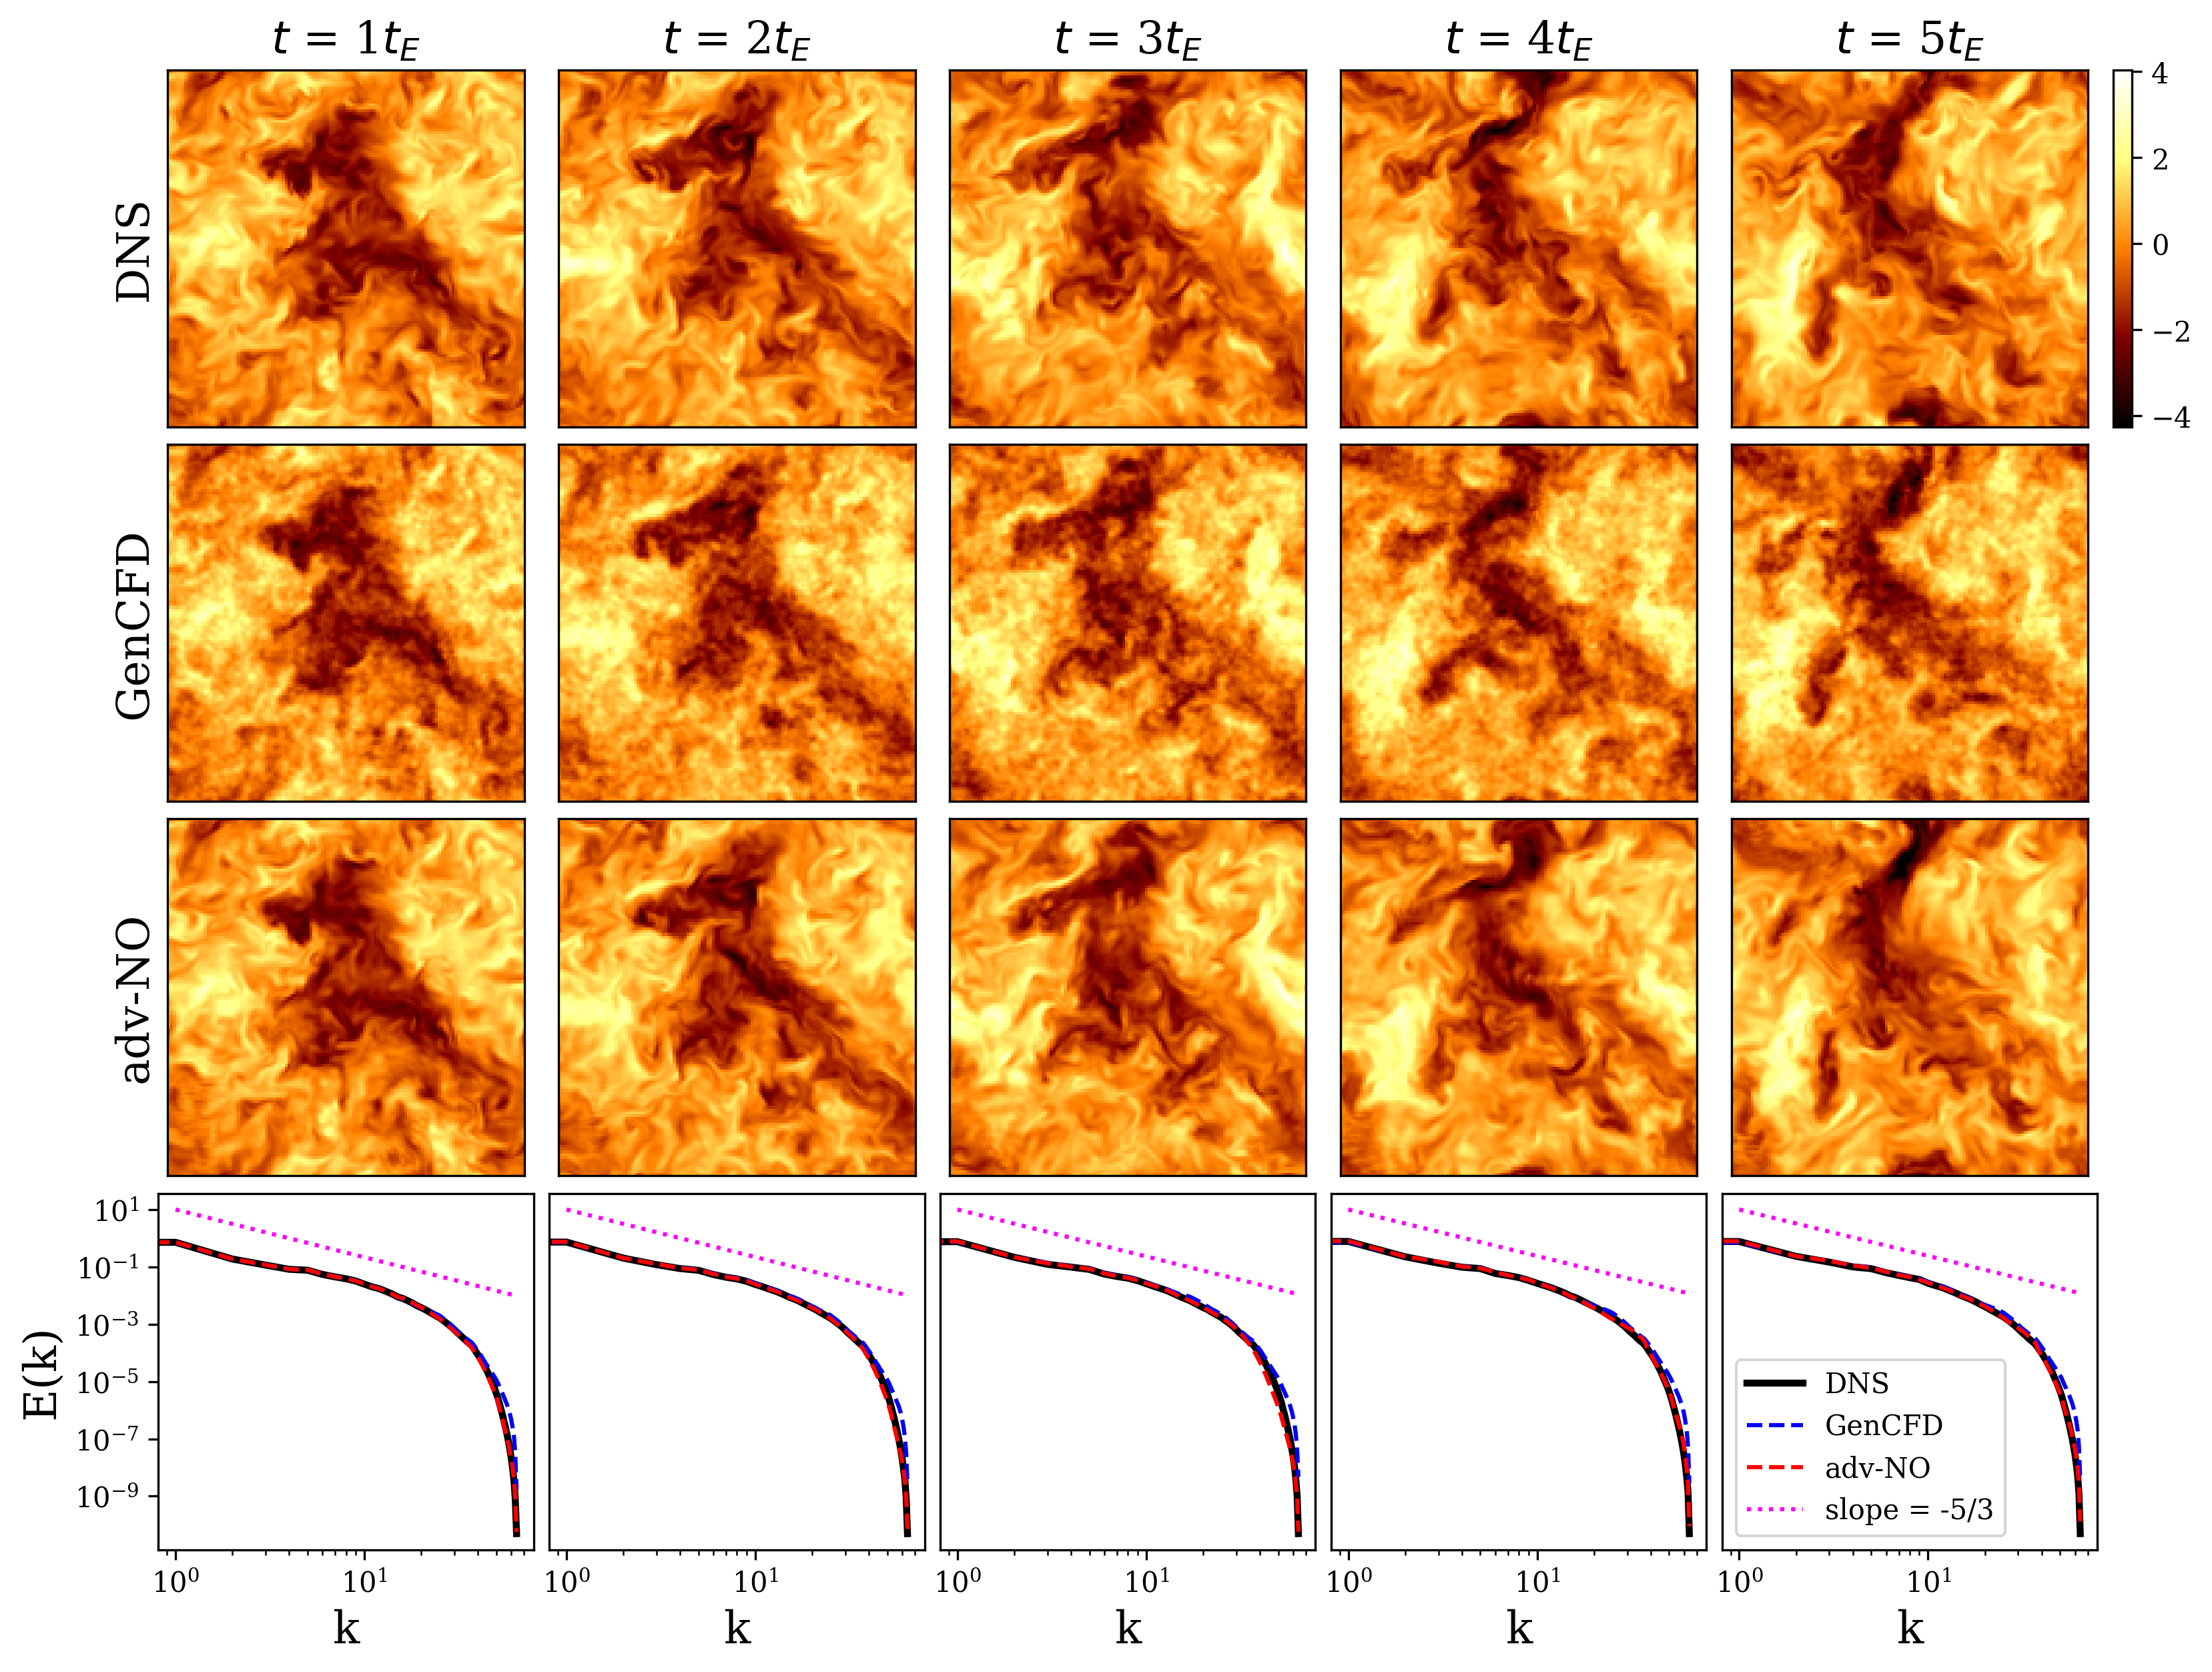

In [23]:
t_ls=[6, 13, 20, 27, 34]
fig, axes = plot_slices_grid(data_ls, t_ls, wave_numbers, spec_ls, f_no=0, z_id=64,
                             y_label_ls=y_label_ls)
plt.show()

/tmp/ipykernel_3824246/799952836.py:138: RuntimeWarning: divide by zero encountered in power
  ax.loglog(wave_numbers, 10 * wave_numbers**(-5/3), label="slope = -5/3", color="magenta", ls="dotted")
/tmp/ipykernel_3824246/799952836.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


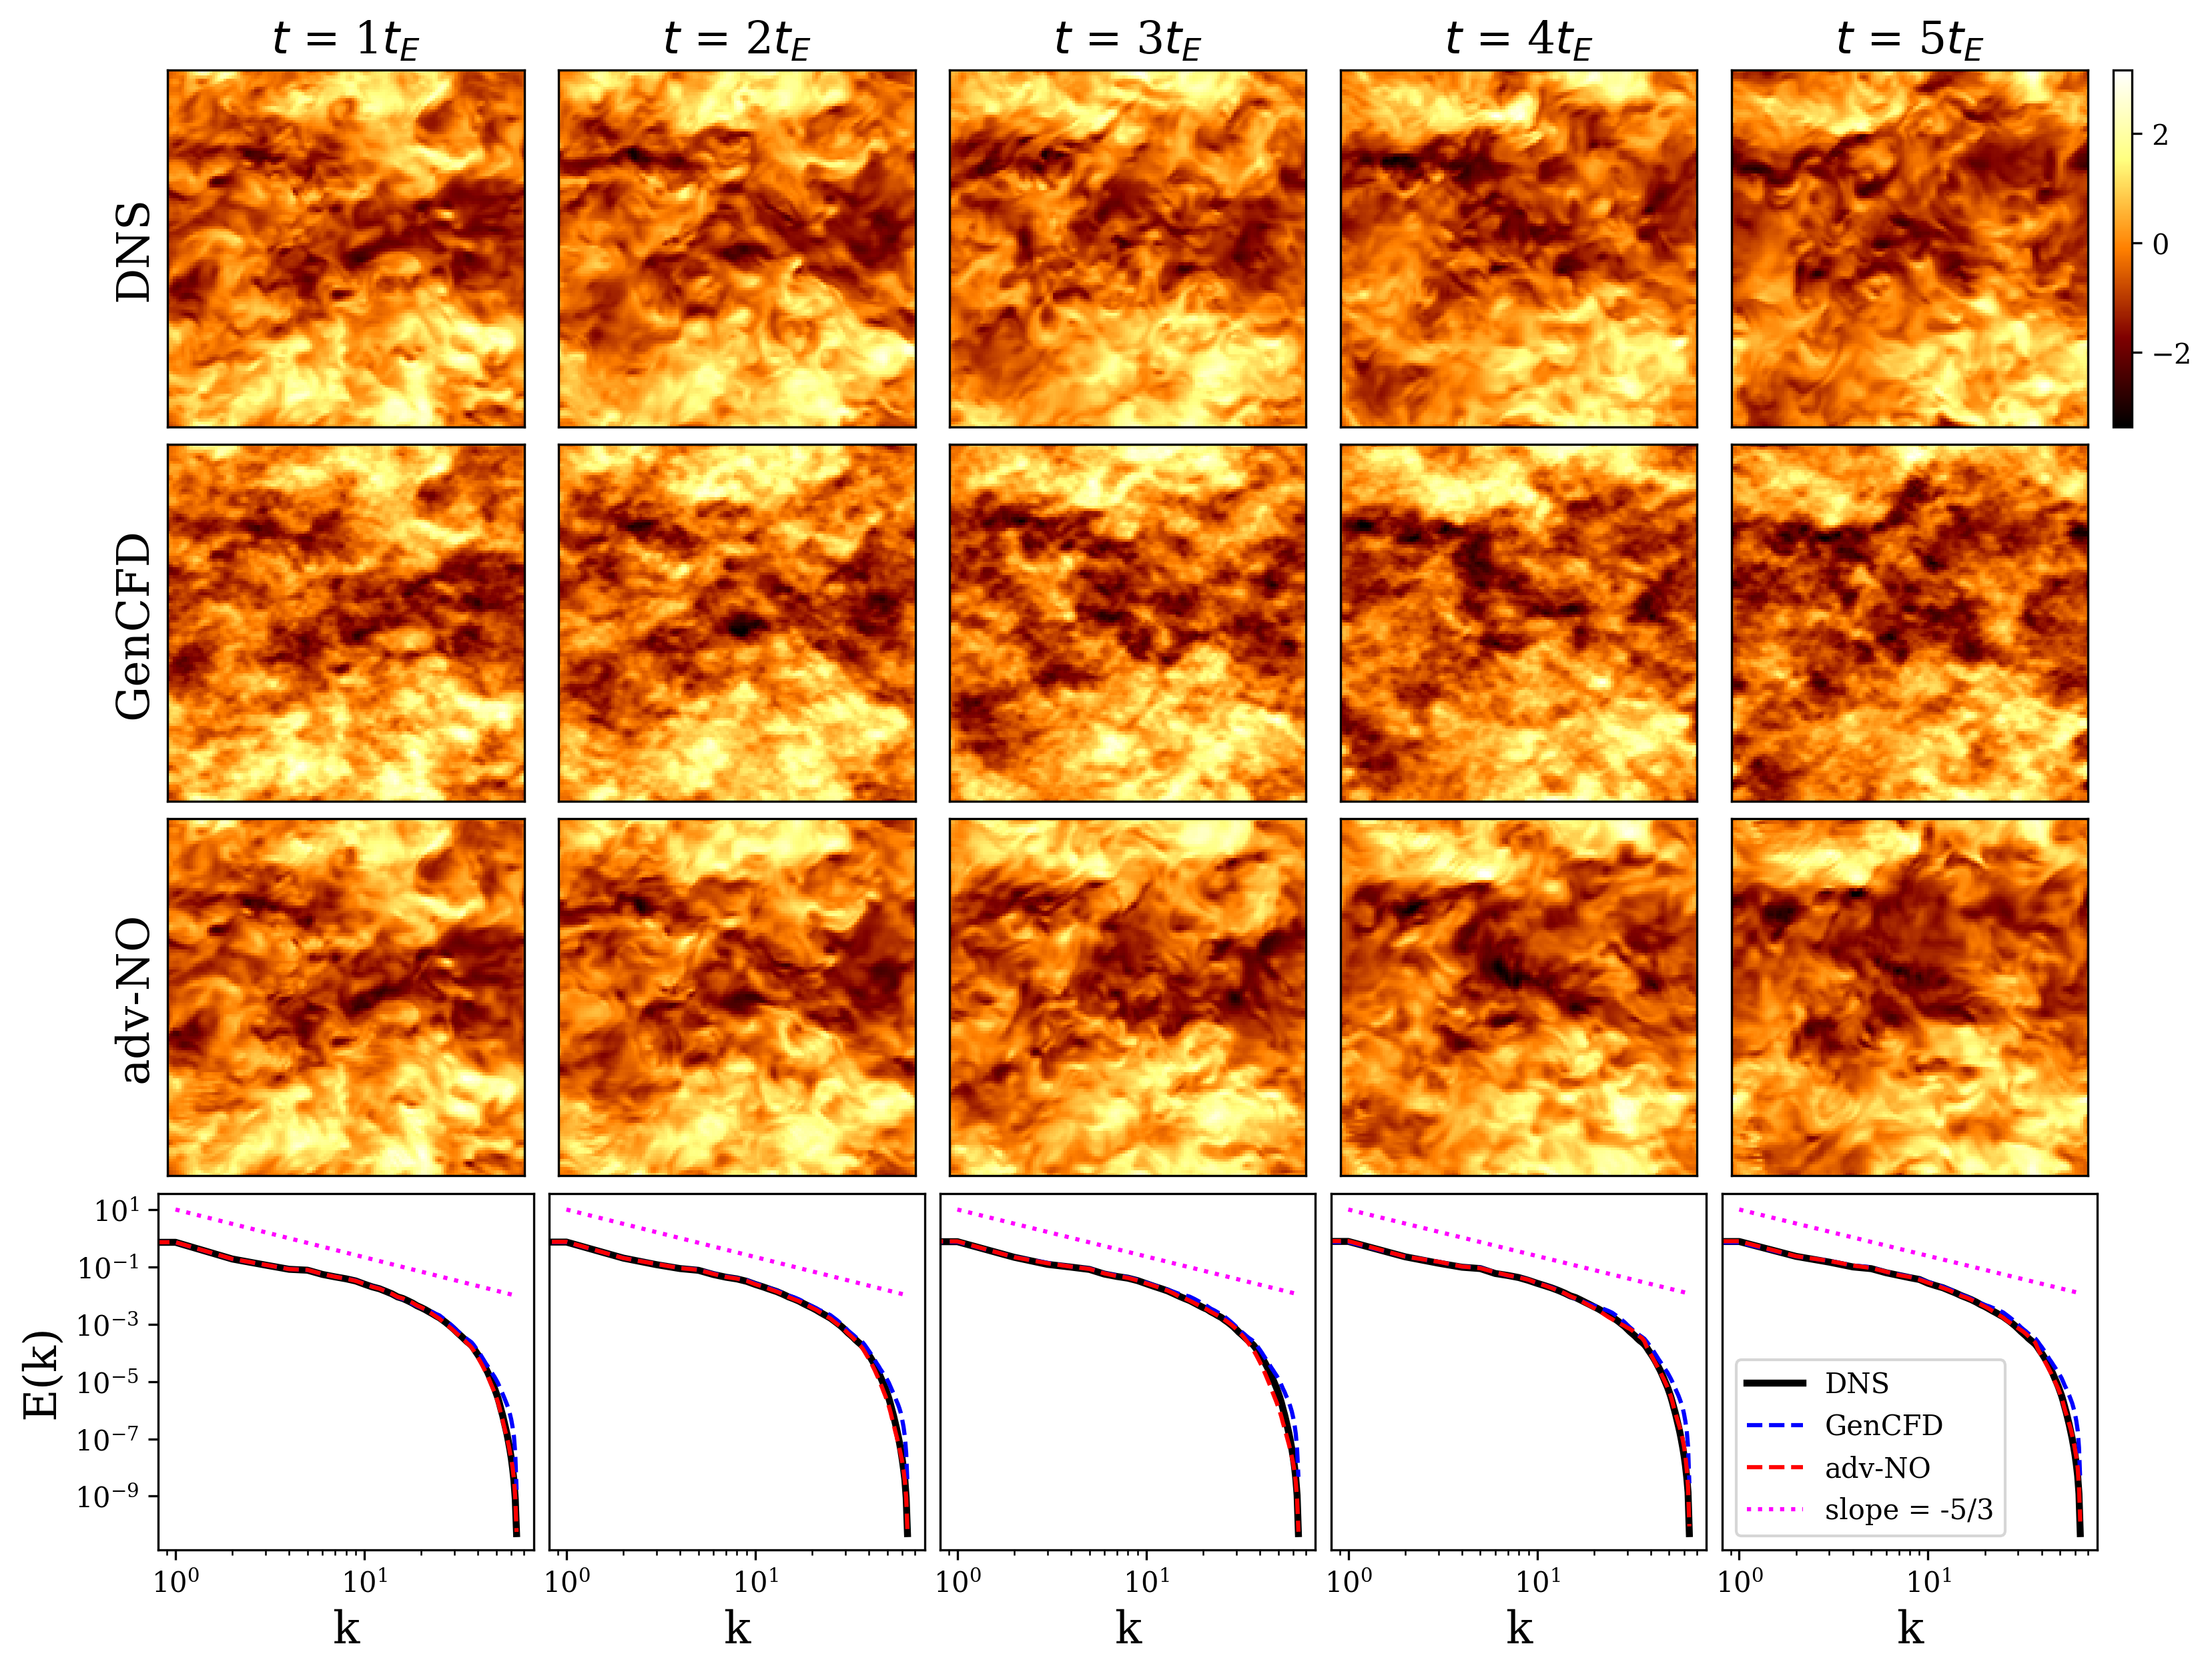

In [24]:
t_ls=[6, 13, 20, 27, 34]
fig, axes = plot_slices_grid(data_ls, t_ls, wave_numbers, spec_ls, f_no=1, z_id=64,
                             y_label_ls=y_label_ls)
plt.show()

/tmp/ipykernel_3824246/799952836.py:138: RuntimeWarning: divide by zero encountered in power
  ax.loglog(wave_numbers, 10 * wave_numbers**(-5/3), label="slope = -5/3", color="magenta", ls="dotted")
/tmp/ipykernel_3824246/799952836.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


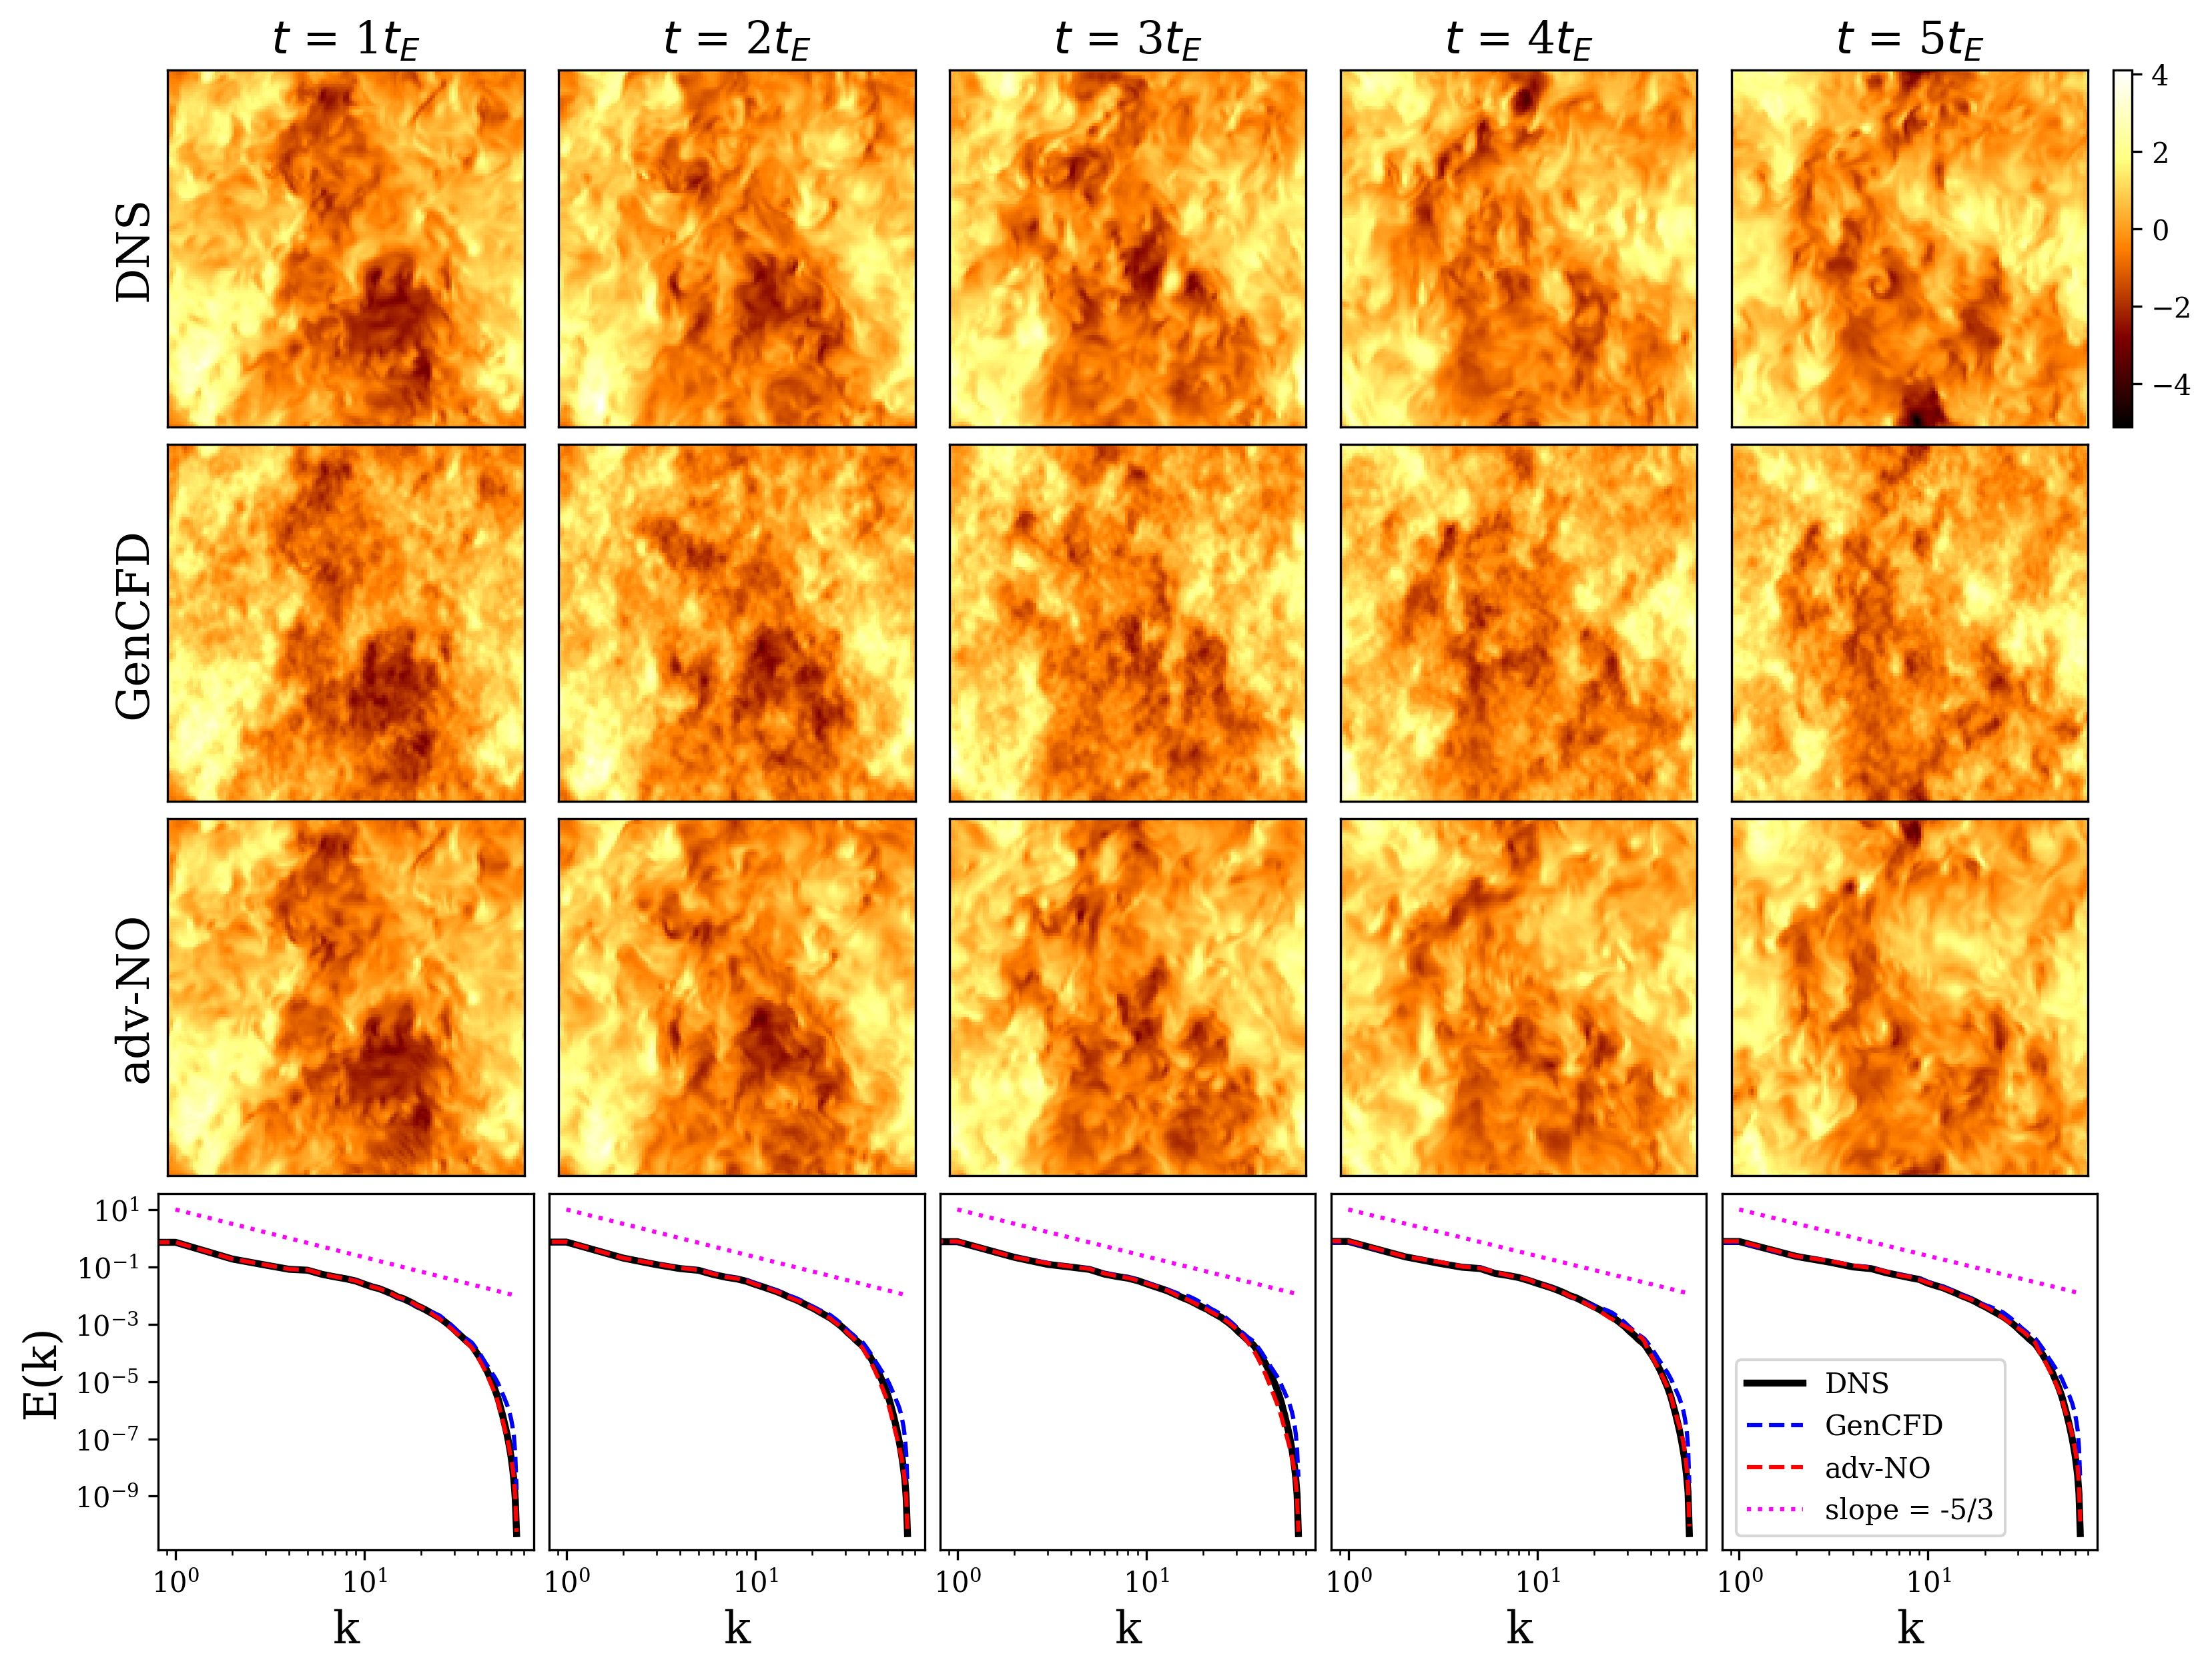

In [25]:
t_ls=[6, 13, 20, 27, 34]
fig, axes = plot_slices_grid(data_ls, t_ls, wave_numbers, spec_ls, f_no=2, z_id=64,
                             y_label_ls=y_label_ls)
plt.show()

In [25]:
for i in range(1,len(data_ls),1):
    err = np.mean((data_ls[i][:,:3] - data_ls[0][:,:3])**2)
    print(f"MSE ({y_label_ls[i]}): {err:.3e}")


MSE (GenCFD): 3.384e-01
MSE (adv-NO): 2.294e-01


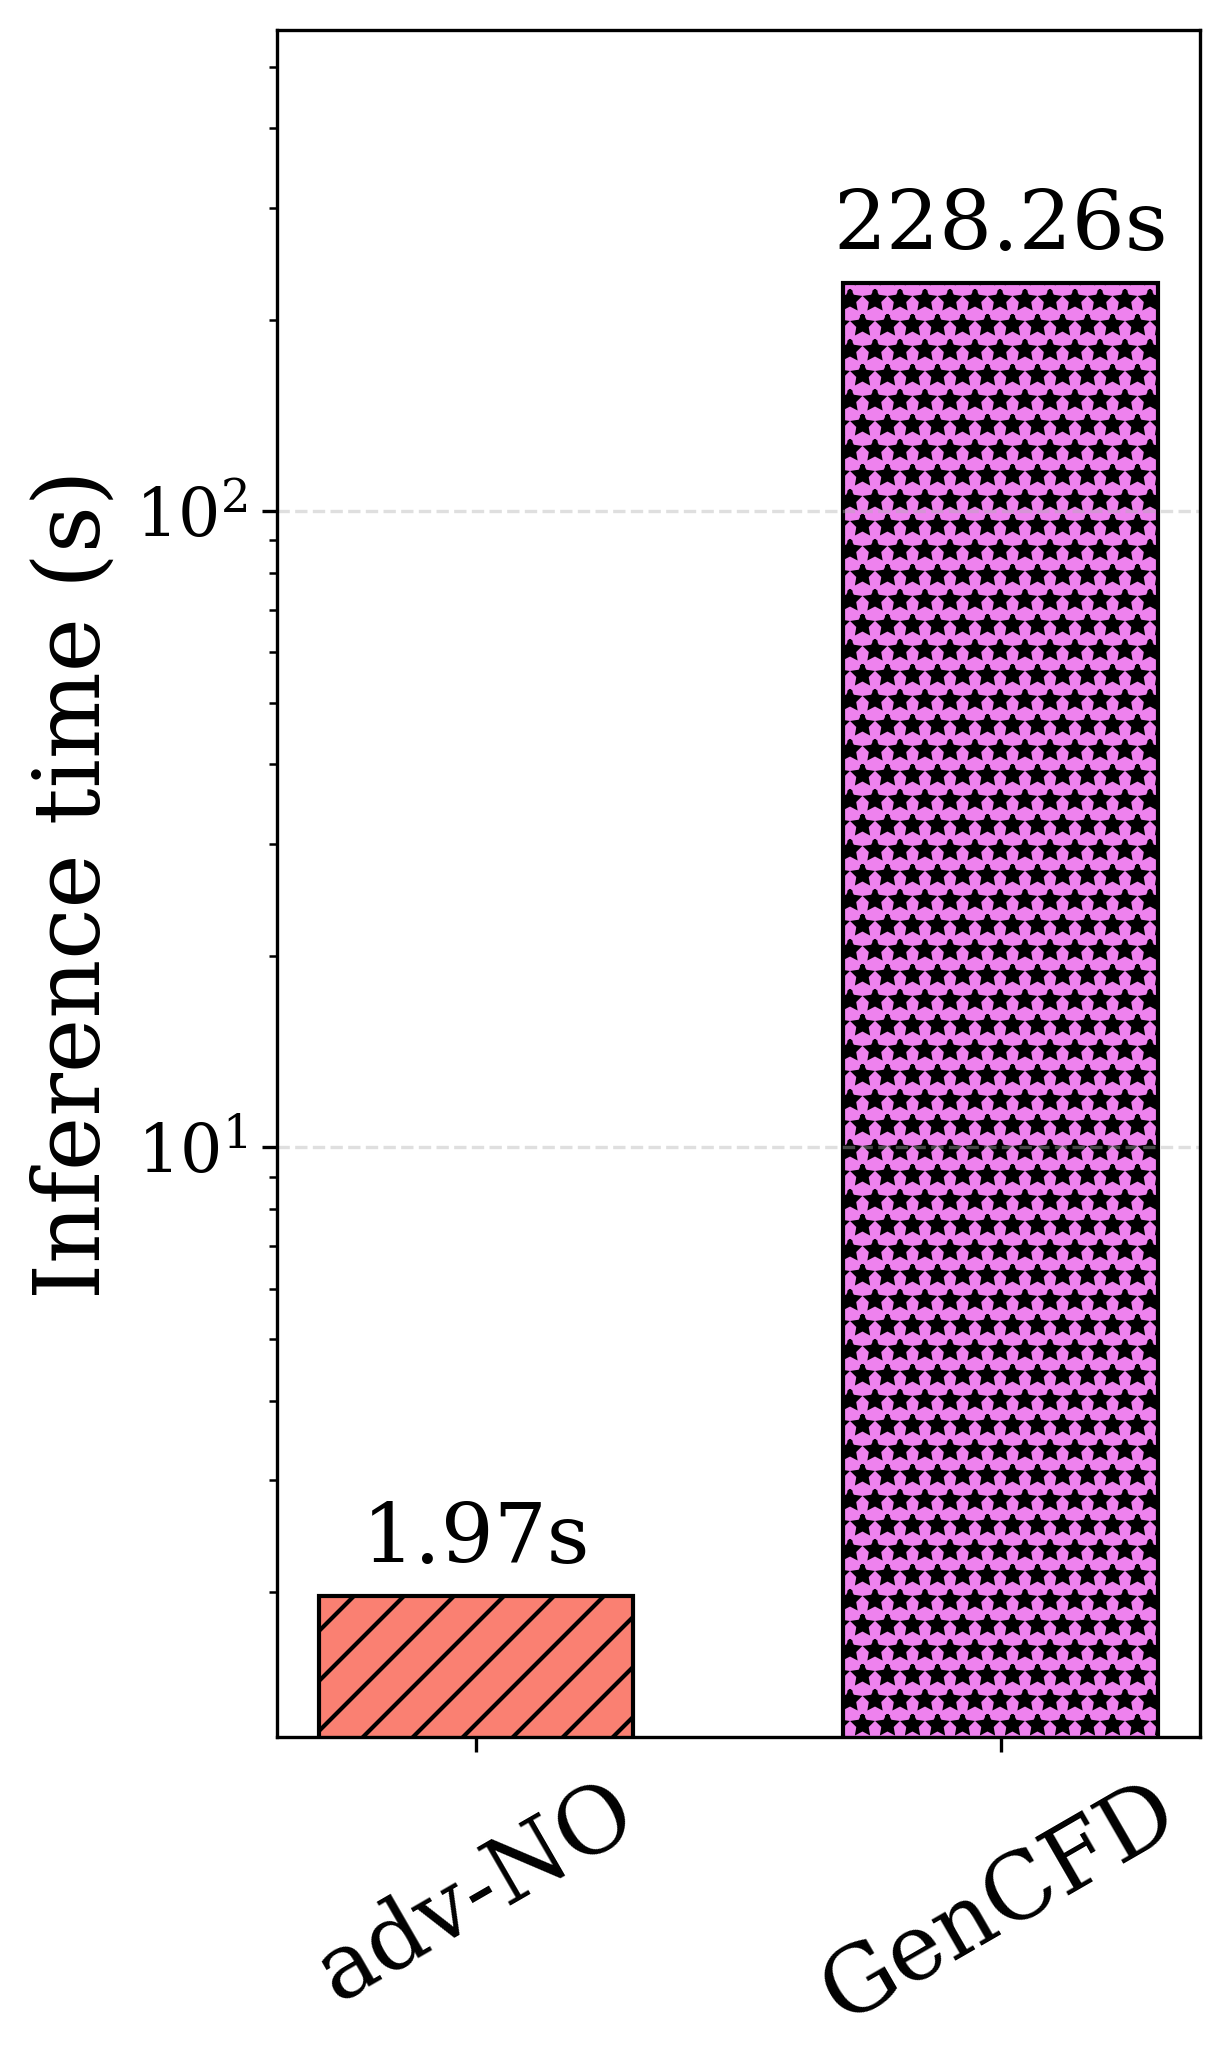

In [23]:
import matplotlib.pyplot as plt

# Models and corresponding inference times (seconds)
models = ['adv-NO', 'GenCFD']
times  = [1.97, 228.26]

# Bar designs: color + hatch pattern (kept to match your style)
colors  = ['salmon', 'violet']
hatches = ['//', '**']

f = 1.4
fig, ax = plt.subplots(figsize=(3*f, 5*f))
bars = []

# Plot each bar
for i in range(len(models)):
    bars.append(
        ax.bar(models[i], times[i],
               color=colors[i],
               hatch=hatches[i],
               width=0.6,
               edgecolor='black')
    )

# Labels & formatting
ax.set_ylabel('Inference time (s)', fontsize=22)
plt.xticks(rotation=30, fontsize=22)
plt.yticks(fontsize=16)

# --- Log scale ---
ax.set_yscale('log')

# Reasonable log-friendly limits (no zeros on log scale)
ymin = min(t for t in times if t > 0) * 0.6
ymax = max(times) * 2.5
ax.set_ylim(ymin, ymax)

# Numbers above bars
for bar in bars:
    for rect in bar:
        h = rect.get_height()
        ax.annotate(f'{h:.2f}s',
                    xy=(rect.get_x() + rect.get_width()/2, h),
                    xytext=(0, 4), textcoords="offset points",
                    ha='center', va='bottom', fontsize=20)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
